# M2D-CLAP example

This is an example of CLAP part of our Interspeech 2024 paper.

```bibtex
@InProceedings{	  niizumi2024M2D-CLAP,
  title		= {{M2D-CLAP: Masked Modeling Duo Meets CLAP for Learning General-purpose Audio-Language Representation}},
  author	= {Daisuke Niizumi and Daiki Takeuchi and Yasunori Ohishi and Noboru Harada and Masahiro Yasuda and Shunsuke Tsubaki and Keisuke Imoto},
  year		= {2024},
  booktitle	= {Interspeech},
  pages		= {57--61},
  doi		= {10.21437/Interspeech.2024-29},
  issn		= {2958-1796}}
```

In [1]:
import warnings; warnings.simplefilter('ignore')
import logging
logging.basicConfig(level=logging.INFO)
import sys
sys.path.append('..')
import torch
from pathlib import Path
import numpy as np

In [2]:
from portable_m2d import PortableM2D
weight = 'm2d_clap_vit_base-80x608p16x16-240128/checkpoint-300.pth'
model = PortableM2D(weight_file=weight, flat_features=True)


 using default norm_stats: tensor([-7.1000,  4.2000])


INFO:root:<All keys matched successfully>
INFO:root:Model input size: [80, 608]
INFO:root:Using weights: m2d_clap_vit_base-80x608p16x16-240128/checkpoint-300.pth
INFO:root:Feature dimension: 768
INFO:root:Norm stats: -7.099999904632568, 4.199999809265137
INFO:root:Runtime MelSpectrogram(16000, 400, 400, 160, 80, 50, 8000):
INFO:root:MelSpectrogram(
  Mel filter banks size = (80, 201), trainable_mel=False
  (stft): STFT(n_fft=400, Fourier Kernel size=(201, 1, 400), iSTFT=False, trainable=False)
)


 using 155 parameters, while dropped 251 out of 406 parameters from m2d_clap_vit_base-80x608p16x16-240128/checkpoint-300.pth
 (dropped: ['mask_token', 'decoder_pos_embed', 'logit_scale', 'decoder_embed.weight', 'decoder_embed.bias'] ...)
<All keys matched successfully>


In [3]:
files = ['AudioSetWav16k/eval_segments/-22tna7KHzI_28.000.wav',
    'AudioSetWav16k/eval_segments/-0xzrMun0Rs_30.000.wav',
    'AudioSetWav16k/eval_segments/3tUlhM80ObM_0.000.wav',
    'AudioSetWav16k/eval_segments/-1nilez17Dg_30.000.wav',
    'AudioSetWav16k/eval_segments/--U7joUcTCo_0.000.wav',
    'AudioSetWav16k/eval_segments/5hlsVoxJPNI_30.000.wav',]
captions = ['The sound of Explosion.',
    'The sound of Stomach rumble, and Music.',
    'The sound of Knock.',
    'The sound of Heart murmur, and Speech.',
    "A man's laughter abruptly interrupts as someone sneezes, suggesting a casual gathering or social event.",
    "The sound of Christmas music, Music, and Speech.",]

In [4]:
import librosa

with torch.no_grad():
    audios = [librosa.load(f, sr=16000)[0] for f in files]
    audios = [np.pad(a, (0, 16000 * 10 - a.shape[-1])) for a in audios]  # Make sure all files are 10-s.
    audios = torch.tensor(audios)
    audio_embs = model.encode_clap_audio(audios)
    text_embs = model.encode_clap_text(captions)

In [5]:
audio_embs.shape, text_embs.shape

(torch.Size([6, 768]), torch.Size([6, 768]))

[[ 0.08543  0.08029  0.02879  0.01966  0.00866 -0.00212]
 [-0.0049   0.06878  0.02576 -0.00711 -0.02833  0.01233]
 [ 0.04179  0.01696  0.13246 -0.00467  0.01645 -0.00098]
 [-0.00217  0.0425  -0.00594  0.10569 -0.00474  0.00028]
 [ 0.05769  0.02339  0.04664  0.01432  0.08724  0.02567]
 [-0.04205 -0.00013 -0.04844  0.00155 -0.02319  0.04316]]


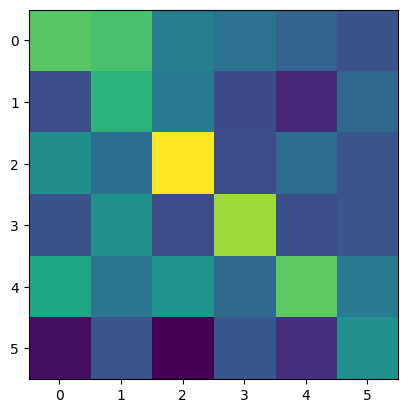

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

H = cosine_similarity(audio_embs, text_embs)
plt.imshow(H, interpolation='none')
np.set_printoptions(precision=5, suppress=True)
print(H)